In [466]:
import pandas as pd
import regex as re
import numpy as np
import copy
import spacy
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.matcher import Matcher
from spacy.util import filter_spans
import re
import matplotlib.pyplot as plt
from collections import Counter
from scipy import spatial
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from DocumentWorking import Document
import sys, importlib

nlp = spacy.load("en_core_web_lg")

/home/blitt/.local/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_lg' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [467]:
def getSpans(spaCyDoc): 
    #now we want to get spans on punctuation 
    spanList = []
    spanStart = 0 
    spanEnd = 0
    for token in spaCyDoc: 
        if token.is_punct: 
            currSpan = spaCyDoc[spanStart:spanEnd]
            spanList.append(currSpan)
            spanStart = spanEnd + 1
        spanEnd += 1
    return spanList

#this inList will be a list of spans 
#TODO: make function that adds noun vectors together and uses those. Also consider 
#how distance should be defined here 
def extractNouns(inList): 
    outList = []
    #get only nouns from the spans 
    for item in inList: 
        tokenList = []
        for token in item: 
            if token.pos_ == "NOUN": 
                tokenList.append(token)
        outList.append(tokenList)
    return outList

def extractPOS(inList, tags): 
    outList = []
    #get only specified parts of speech from spans 
    for item in inList: 
        tokenList = []
        for token in item: 
            if token.pos_ in tags: 
                tokenList.append(token)
        outList.append(tokenList)
    return outList
        
    
def getSumSentVecs(inList): 
    outList = []
    for innerList in inList: 
        if len(innerList) > 0: 
            outList.append(sum([item.vector for item in innerList]))
        else: 
            outList.append(np.array([0 for i in range(0, 300)]))
    return outList

def getVectorDist(inList): 
    outerList = []
    for i in inList: 
        innerList = []
        for j in inList:
            innerList.append(spatial.distance.cosine(i, j))
        outerList.append(innerList)
    return outerList

#input needs to be np.array
def getPCAVectorDist(inArr, nComponents): 
    pca = PCA(n_components=nComponents)
    reducedData = pca.fit_transform(np.array(spanSums))
    print(str(nComponents) + " able to explain " + str(sum(pca.explained_variance_ratio_)) + " of variance")
    return getVectorDist(reducedData)

def getPCANounSimList(inList, nComponents): 
    nouns = extractNouns(inList)
    sentVecs = getSumSentVecs(nouns)
    sims = [[1-dist for dist in inner] for inner in getPCAVectorDist(sentVecs, nComponents)]
    return sims 

def getNounSimList(inList): 
    nouns = extractNouns(inList)
    sentVecs = getSumSentVecs(nouns)
    sims = [[1 - dist for dist in inner] for inner in getVectorDist(sentVecs)] 
    return sims 

def getNounDistList(inList): 
    nouns = extractNouns(inList)
    sentVecs = getSumSentVecs(nouns)
    return getVectorDist(sentVecs) 

def getPOSSimList(inList, tags): 
    posList = extractPOS(inList, tags)
    sentVecs = getSumSentVecs(posList)
    sims = [[1 - dist for dist in inner] for inner in getVectorDist(sentVecs)]
    return sims

In [468]:
#load in Document and nlp modules/objects
from DocumentWorking import Document
import sys, importlib
importlib.reload(sys.modules['DocumentWorking'])

doc = Document("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/AG2PISlides.csv",nlp,subsetColumns=["Persona", "Touchpoint", ["Touchpoint", "Persona"]])
personaDict = doc.getDoubleColSubAttributeDict(["Touchpoint", "Persona"], "workingDoc")

In [469]:
spanList = []
for key, val in personaDict["How do they first discover the existence of AG2PI & what are they looking for?"].items(): 
    spanList += getSpans(val)


#nounSpanList = extractNouns(spanList)
spanSums = getSumSentVecs(nounSpanList)
dissim = getPCAVectorDist(spanSums, 30)

#dissim = getNounDistList(spanList)
dissim

30 able to explain 0.9466812869338663 of variance


[[0,
  1.2619712113308879,
  0.9461533919730042,
  1.2563591040994728,
  1.171562996585179,
  0.8764150658131785,
  0.8425510744068627,
  0.8234781508046416,
  0.7655146390431857,
  1.003421888157967,
  1.087275134925328,
  1.2085742194905569,
  0.9793099472183592,
  0.5034683008063647,
  0.625870583544937,
  1.3774216167657787,
  0.953574238309059,
  1.093960345847016,
  1.3507212184581012,
  0.8425510744068628,
  0.8943711331365005,
  0.9351284591687952,
  1.2782265184261716,
  0.949152086108135,
  1.2396527819431375,
  0.8943711331365004,
  1.0970484069927688,
  0.946153391973004,
  0.625870583544937,
  0.9495765850587966,
  1.1335797236149596,
  0.8363258485265808,
  0.9620662999232844,
  1.1439631292554475,
  0.833209049073054,
  0.923471327712588,
  1.259274171642916,
  0.9766842378071774,
  1.0567556894233996,
  1.0159138770979712,
  1.037651035682167,
  0.8552795839296962,
  1.0159138770979712,
  1.0724923773486077,
  1.3372612076795904,
  2.220446049250313e-16,
  0.62587058354

In [470]:
#check out PCA and tSNE method
spanSums = getSumSentVecs(nounSpanList)
spanSums

#only need 30 out of 300 features to get most of the variance in the data 
pca = PCA(n_components=55)
reducedData = pca.fit_transform(np.array(spanSums))
sum(pca.explained_variance_ratio_)


1.0000000000000002

In [471]:
tsne = TSNE(n_components=2, random_state=25)
projectedData = tsne.fit_transform(reducedData)

/home/blitt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/blitt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


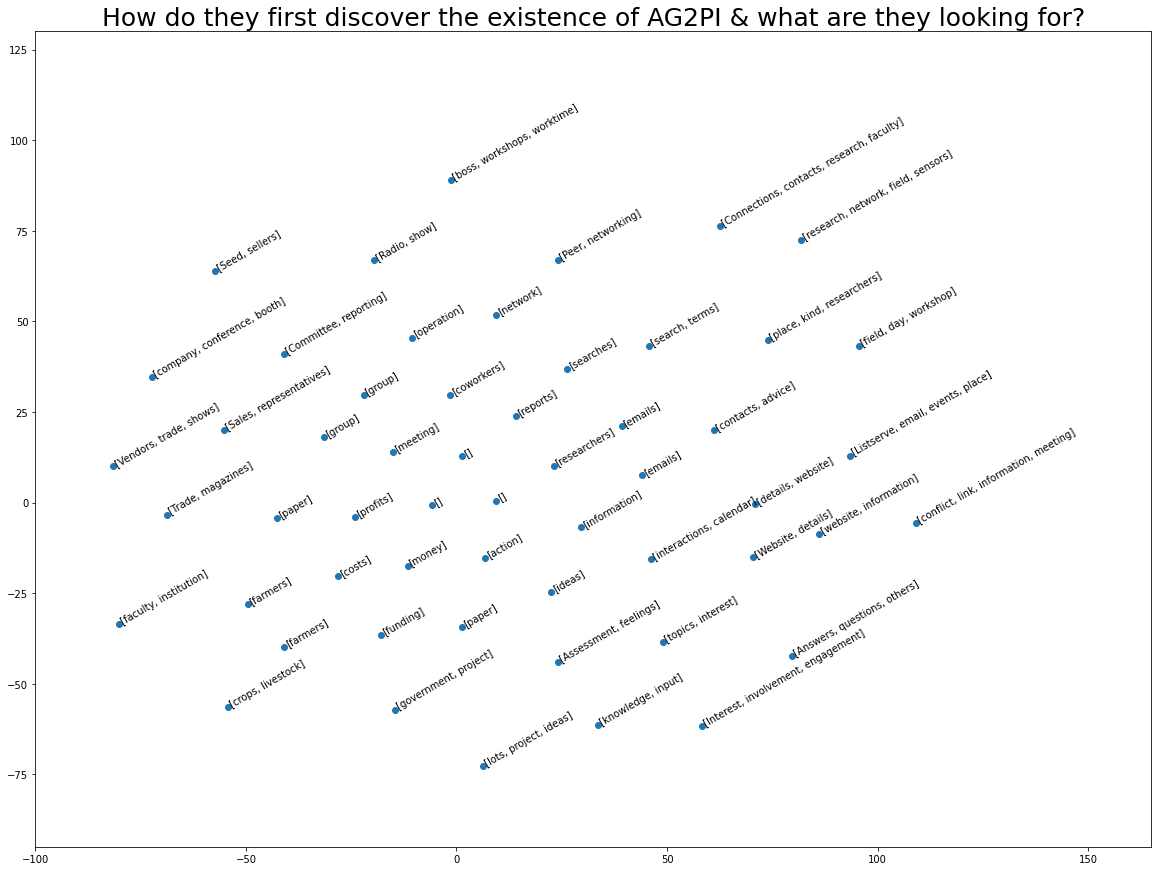

In [534]:
#THIS SEEMS PROMISING
fig = plt.figure(figsize=(20, 15))

ax = fig.gca()

X = projectedData[:,0]
Y = projectedData[:,1]

ax.scatter(X, Y)

for index, lab in enumerate(nounSpanList): 
    ax.text(X[index], Y[index], s=str(lab), rotation=30)

ax.set_xlim(-100, 165)
ax.set_ylim(-95, 130)
ax.set_title("How do they first discover the existence of AG2PI & what are they looking for?")
#ax.xaxis.set_title("hello world")
#plt.show()
plt.savefig("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/mockups/nounVerbTSNEDiscoverQ.jpg")

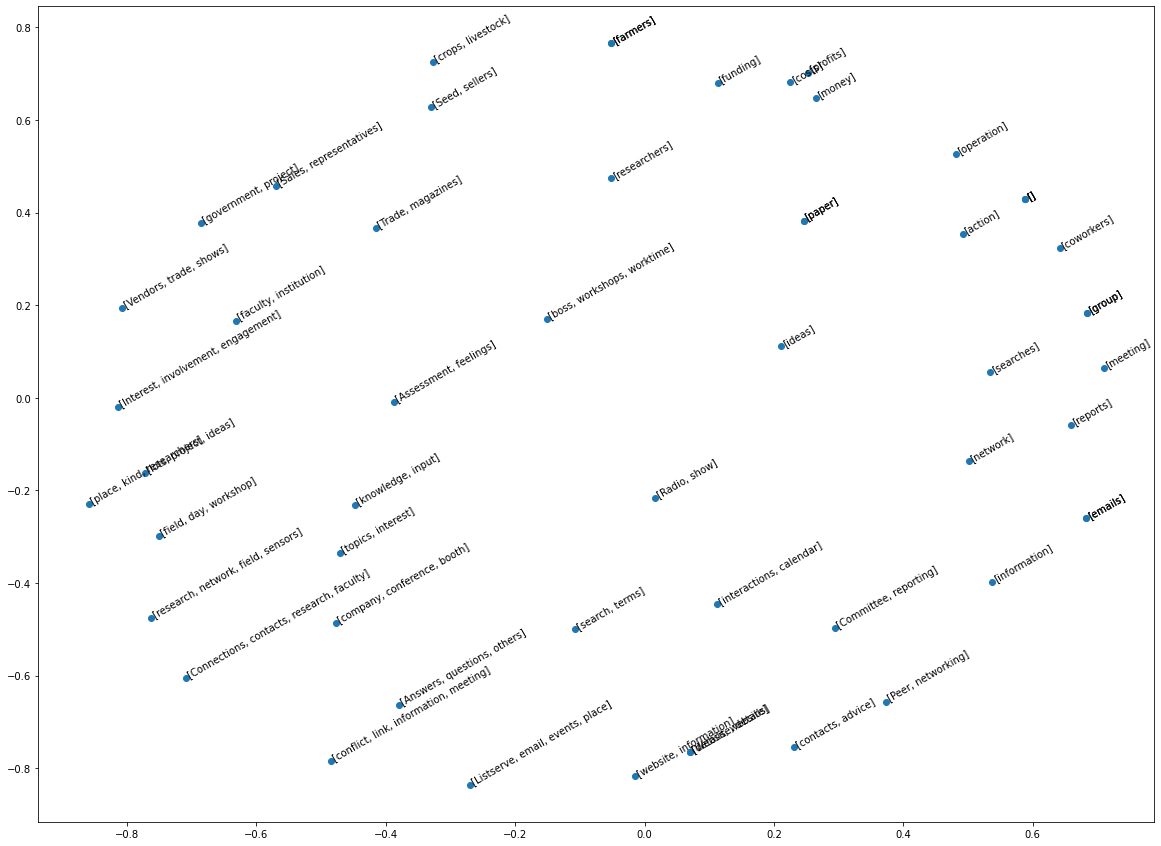

In [453]:
#MDS on distance matrix (doesn't seem as good)
#Hopefully it is the PROJECTION that doesn't work as well not the PCA before distance ideas 
from sklearn.manifold import MDS 

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=3)
fitted = mds.fit_transform(dissim)
fig = plt.figure(figsize=(20, 15))

ax = fig.gca()

X = fitted[:,0]
Y = fitted[:,1]

ax.scatter(X, Y)

for index, lab in enumerate(nounSpanList): 
    ax.text(X[index], Y[index], s=str(lab), rotation=30)
    
plt.show()


In [427]:
#an attempt at writing the code using the new way of splitting when creating the document object 
import importlib
imported_module = importlib.import_module("DocumentWorking")
importlib.reload(imported_module)
from DocumentWorking import *

doc = Document("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/AG2PISlides.csv",nlp,subsetColumns=["Persona", "Touchpoint", ["Touchpoint", "Persona"]])

In [560]:
"""
Subset list is one of the lists from subsetColumns given when initializing the Document object. 
It specifies first what information we will be taking a slice of to create the tree, and 
what information will be used to color the tree. 

cleaningLevel is the level of information that we want to take. Right now we should always use "workingDoc",
since we need actual spaCy documents to get spans and calculate span similarity. 

simFunction. This is a function that will take a list of spans and give us the similarity between them. 

Key is the "slice" to take. 


For example, we could have: 
key = 'How do they first discover the existence of AG2PI & what are they looking for?'
clusterSentEmbeddings(["Touchpoint", "Persona"], "workingDoc", key)

which would take answers to the question "How do they first discover the existence of AG2PI & what are they looking for"
colored by Persona, using text from the workingDoc text created during the automatic cleaning of the data
that occurs when creating Document. 
"""

def clusterNounVerbEmbeddings(subsetList, cleaningLevel, simFunction, inKey, ax=None): 
    #example 
    #personaDict = doc.getDoubleColSubAttributeDict(["Touchpoint", "Persona"], "workingDoc")
    #inKey = 'How do they first discover the existence of AG2PI & what are they looking for?'
    
    personaDict = doc.getDoubleColSubAttributeDict(subsetList, cleaningLevel)
    
    """
    recreate the nested dictionary but get the spans instead of having the working doc
    this dictionary has touchpoints as the outer key and personas as the inner, so we can easily split by persona 
    for a particular toucpoint 
    """
    spanDict = {}
    for outerKey in personaDict.keys():
        spanDict[outerKey] = {}
        for innerKey in personaDict[outerKey].keys(): 
            spanDict[outerKey][innerKey] = getSpans(personaDict[outerKey][innerKey]) 

    #we most likely also only want to get dictionaries for one value of the touchpoint 
    keyDictSpans = spanDict[inKey]

    #now add spaces so there are technically no double spans in keyDict
    #use temporary dictionary to hold items while changing them 
    inSpans = {}

    #need to do deepcopy here
    keyDict = {}

    for key in keyDictSpans.keys(): 
        keyDict[key] = [None for item in range(0, len(keyDictSpans[key]))]
        for index, span in enumerate(keyDictSpans[key]): 
            spaceSpan = str(span)

            #add as many spaces to this span as needed so that there are no doubles, tripes
            #etc.. in our span list when we go to create plot/assign colors 
            while spaceSpan in inSpans: 
                spaceSpan += " "

            inSpans[spaceSpan] = True 

            #replace non-spaced version of span with space span 
            keyDict[key][index] = spaceSpan

    #get colors, map to keys in dictionary created above
    colorListFull = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf", "#999999"]
    colorListFull = [item.upper() for item in colorListFull]
    colorKeyMapping = dict(zip(sorted(list(keyDict.keys())), colorListFull[:len(keyDict.keys())]))

    #make sure legend order matches with colors
    legendElements = []
    for index, key in enumerate(sorted(list(keyDict.keys()))):
        currColor = colorListFull[index]
        legendElements.insert(0, Patch(facecolor=currColor,label=key))

    #map each span to the color associated with its key in keyDict
    #this way we can easily grab the color for any span when plotting 
    colorSpanMapping = {
        str(span):colorKeyMapping[key]
        for key, val in keyDict.items()
        for span in val}

    #NOTE: we should be ok matching the spans to the strings because we sort the keys when we iterate 
    #and we maintain the order of items in the lists within keyDictSpans 
    #create list of all spans 
    spanList = []
    for k in sorted(list(keyDictSpans.keys())): 
        spanList += keyDictSpans[k]

    #create list of all string versions of spans (with spaces )
    labelList = []
    for k in sorted(list(keyDict.keys())): 
        labelList += keyDict[k]
    
    simList = simFunction(spanList, ["NOUN", "VERB", "ADJ", "ADV"])
    simList = np.array(simList)
    
    #get linkage 
    linked = linkage(simList, "complete")

    #COLORING 
    #black
    defaultColor = "#000000" 

    link_cols = {}

    #go through only the first two columns of the linkage matrix (which contain linkage information)
    #enumerate gives both an index (i) and the object in our data source (a 2d row of linkage)
    for i, i12 in enumerate(linked[:,:2].astype(int)):

        #for x in i12 iterates through nodes linked in this cluster
        #gets the color of either the nodes (if leaves) or subtrees (if not leaves i.e. x > len(Z)) being linked
        c1, c2 = (link_cols[x] if x > len(linked) else colorSpanMapping[labelList[x]] for x in i12) 

        #if the colors are the same, then make merged tree of c1 and c2 (located at i + 1 + len(Z)) have same color 
        #as the subtrees. IF NOT, simply use default color 
        #link_cols[i+1+len(linked)] = c1 if (c1 == c2 or i12[0] < len(linked) or i12[1] < len(linked)) else defaultColo
        link_cols[i+1+len(linked)] = c1 if (c1 == c2) else defaultColor

    #the link function is basically saying, what should I color the upside-down U part of the tree that 
    #links two subtrees 
    
    if ax is None: 
        ax = plt.gca()
        
    D = dendrogram(Z=linked, labels=labelList, orientation="left",color_threshold=None, link_color_func=lambda x: link_cols[x])
    
    print(colorSpanMapping)
    #note that the axis labels are text objects 
    for leaf in ax.yaxis.get_ticklabels():
        leaf.set_color(colorSpanMapping[leaf.get_text()])
    
    ax.legend(handles=legendElements,loc='upper left')
    #ax.set_title(inKey)
    print(inKey)
    return ax

In [520]:
#what are the possible keys to pass to clusterSentEm
doc.dataFrame["Touchpoint"].unique()

array(['How do they first discover the existence of AG2PI & what are they looking for?',
       'How do they stay in contact with AG2PI ',
       'How do they get information from AG2PI & learn of new activities or opportunities ',
       'How can they share their expertise with AG2PI ',
       'What is defined as a successful interaction ',
       'How can they share information with/to AG2PI '], dtype=object)

/home/blitt/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


{'Signing up for list serves': '#984EA3', 'Email  calling Pis or admin support people': '#984EA3', 'Setting up the actual interaction is an interaction in itself  and can be positive or negative based on how easy it is to achieve': '#984EA3', 'Attending workshopsevents': '#984EA3', 'Making phone calls': '#984EA3', 'Reading emails  need to keep them engaging or at this point Susan will let emails float down to junk status': '#984EA3', 'Feel like a part of the team when reading from listserve': '#984EA3', 'Learning about the others in the group': '#984EA3', 'Looking for listserves to join': '#984EA3', 'Looking into resources related to their research': '#984EA3', 'Finding contact information to start reaching out': '#984EA3', 'Email': '#984EA3', 'Phone': '#984EA3', 'Listserve': '#984EA3', 'Reading about events that will happen soon': '#984EA3', 'Excited to have a contact': '#984EA3', 'Hopeful': '#984EA3', 'Worried things wont pan out': '#984EA3', 'Afraid that she might have to share IP a

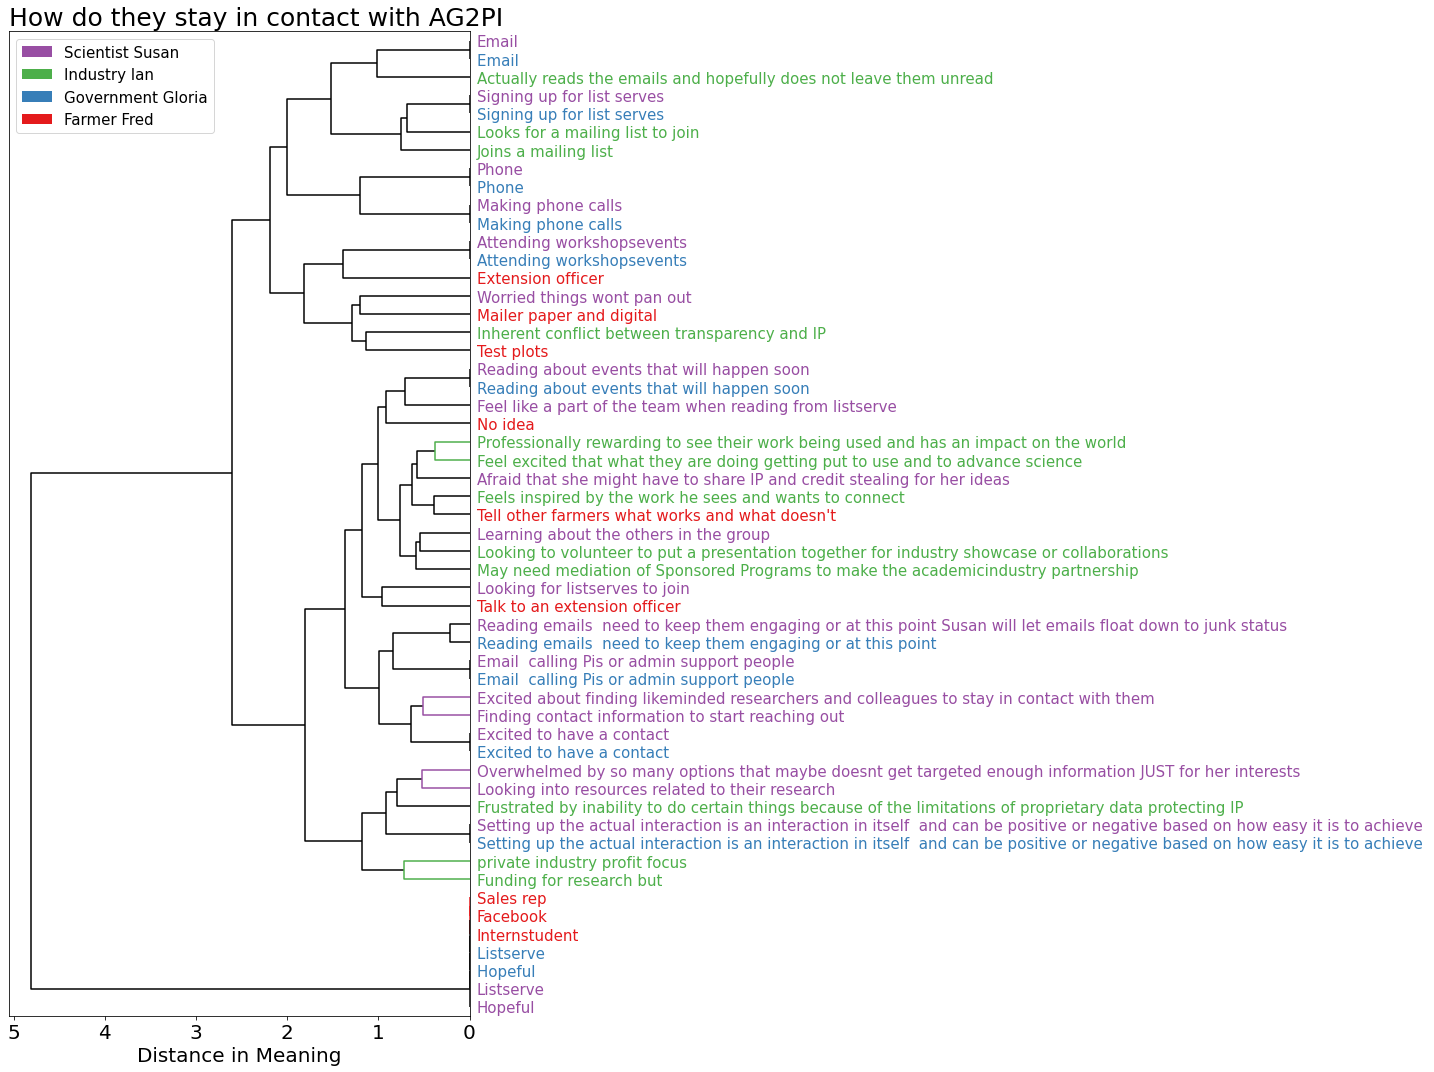

In [536]:
plt.figure(figsize=(20, 15))
ax = clusterNounVerbEmbeddings(["Touchpoint", "Persona"], "workingDoc", getPOSSimList, "How do they stay in contact with AG2PI ")
#D = dendrogram(Z=linked, labels=labelList, orientation="left",color_threshold=None, link_color_func=lambda x: link_cols[x])
ax.tick_params("y", labelsize=15)
ax.tick_params("x", labelsize=20)
#ax.tick_params(axis='both', which='major', labelsize=20)
#plt.rcParams["xtick.labelsize"] = 30
#plt.rcParams["ytick.labelsize"] = 20
ax.set_xlabel("Distance in Meaning", size=20)
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["axes.titlesize"] = 25
#ax.rc('legend',fontsize=15)
#ax.rc("axes", titlesize=25)
#ax.rc("")
ax.set_title("How do they stay in contact with AG2PI ", loc="left")
plt.tight_layout()
plt.savefig("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/mockups/nounVerbSimStayContactQ.jpg")

In [553]:
#access embeddings with "trf_data.tensors" 
def getSumSentBERTVecs(inList): 
    outList = []
    for innerList in inList: 
        #we may have some sentances with no nouns 
        if len(innerList) > 0: 
            outList.append(np.array([item._.BERTVec for item in innerList]).mean(axis=0))
        else: 
            outList.append(np.array([0 for i in range(0, 768)]))
    return np.array(outList)


def getVectorDist(inList): 
    outerList = []
    for i in inList: 
        innerList = []
        for j in inList:
            innerList.append(spatial.distance.cosine(i, j))
        outerList.append(innerList)
    return outerList

def getNounSimList(inList): 
    nouns = extractNouns(inList)
    sentVecs = getSumSentVecs(nouns)
    sims = [[1 - dist for dist in inner] for inner in getVectorDist(sentVecs)] 
    return sims 

def getNounDistList(inList): 
    nouns = extractNouns(inList)
    sentVecs = getSumSentVecs(nouns)
    return getVectorDist(sentVecs) 

def getPOSBERTSimList(inList, tags): 
    posList = extractPOS(inList, tags)
    sentVecs = getSumSentBERTVecs(posList)
    sims = [[1 - dist for dist in inner] for inner in getVectorDist(sentVecs)]
    return sims

In [544]:
#load in Document and nlp modules/objects
from DocumentWorking import Document
import sys, importlib
importlib.reload(sys.modules['DocumentWorking'])

#perform a similar task but cluster nouns using contextual embeddings!
#first need to test loading a transformer spacy pipeline 
nlp = spacy.load("en_core_web_trf")

doc = Document("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/AG2PISlides.csv",nlp,subsetColumns=["Persona", "Touchpoint", ["Touchpoint", "Persona"]])


In [545]:
def initBERTVecs(): 
    #flatten batches so we just have one long list of tensors, one for each wordpeice that 
    #was input to roBERTa 
    allTensors = []
    for batch in doc.workingDoc._.trf_data.tensors[0]:
        for item in batch: 
            allTensors.append(item) 

    #use the align data to map the vectors from roBERTa to the 
    #tokens generated by the stock spaCy tokenizer 
    outArr = []
    for index, alignData in enumerate(doc.workingDoc._.trf_data.align): 
        #print(item.data)
        #index that the current vector aligns with)

        #doc indices that this current vector belongs too 
        currTensors = [allTensors[vectorIndex[0]] for vectorIndex in alignData.dataXd]

        #NOTE: we may want to try something other than average pooling but this seems to make sense 
        if len(currTensors) > 0: 
            outArr.append(np.array(currTensors).mean(axis=0))
        else: 
            outArr.append(np.array([0 for i in range(0, 768)]))

    """
    quick sanity check for getting a mean 
    prac = np.array([[1, 2, 3],[4, 5, 6]])
    prac.mean(axis=0)
    """

    def getBERTVec(inToken): 
        return outArr[inToken.i]

    #give each token a vector so that we can work under a similar framework as above 
    for i, tok in enumerate(doc.workingDoc): 
        tok.set_extension("BERTVec", getter=getBERTVec, force=True)

    """
    #make sure it works 
    for example in doc.workingDoc[:4]: 
        print(example._.BERTVec)
    """
    
initBERTVecs()

In [577]:
#create a minimum working example for testing purposes 
spanList = []
for key, val in personaDict["How do they first discover the existence of AG2PI & what are they looking for?"].items(): 
    spanList += getSpans(val)

#thisTry = np.array([np.array([1, 2, 3]), np.array([4, 5, 6])])
nounList = extractPOS(spanList, ["NOUN", "VERB"])
sumList = getSumSentBERTVecs(spanList)

#n_samples, n_features is the right shape for PCA
#try without normalization first? 
sumList

array([[-0.286531  ,  0.00304945, -0.0602526 , ...,  0.42938492,
        -0.13891397, -0.18174097],
       [-0.29198581, -0.06864055, -0.4616918 , ...,  0.35830015,
         0.09291072,  0.04582486],
       [ 0.04407016, -0.40094241, -0.02647883, ...,  0.52668101,
         0.38430151, -0.03931063],
       ...,
       [-0.40805158,  0.14188699, -0.2619935 , ...,  0.61984307,
         0.236147  ,  0.32507324],
       [ 0.57614881, -0.00775324, -0.40809965, ..., -1.46953237,
        -0.37873685,  0.19065759],
       [-0.26379594, -0.08774531, -0.96021599, ...,  0.36635399,
         0.12983939,  0.13716085]])

In [573]:
#perform visualization using PCA and tSNE
#interestingly, we can explain ~97% percent of the variance with 30 components here 
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
reducedData = pca.fit_transform(sumList)
sum(pca.explained_variance_ratio_)

0.9821795109864384

In [574]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=25)
projectedData = tsne.fit_transform(reducedData)

/home/blitt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/blitt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


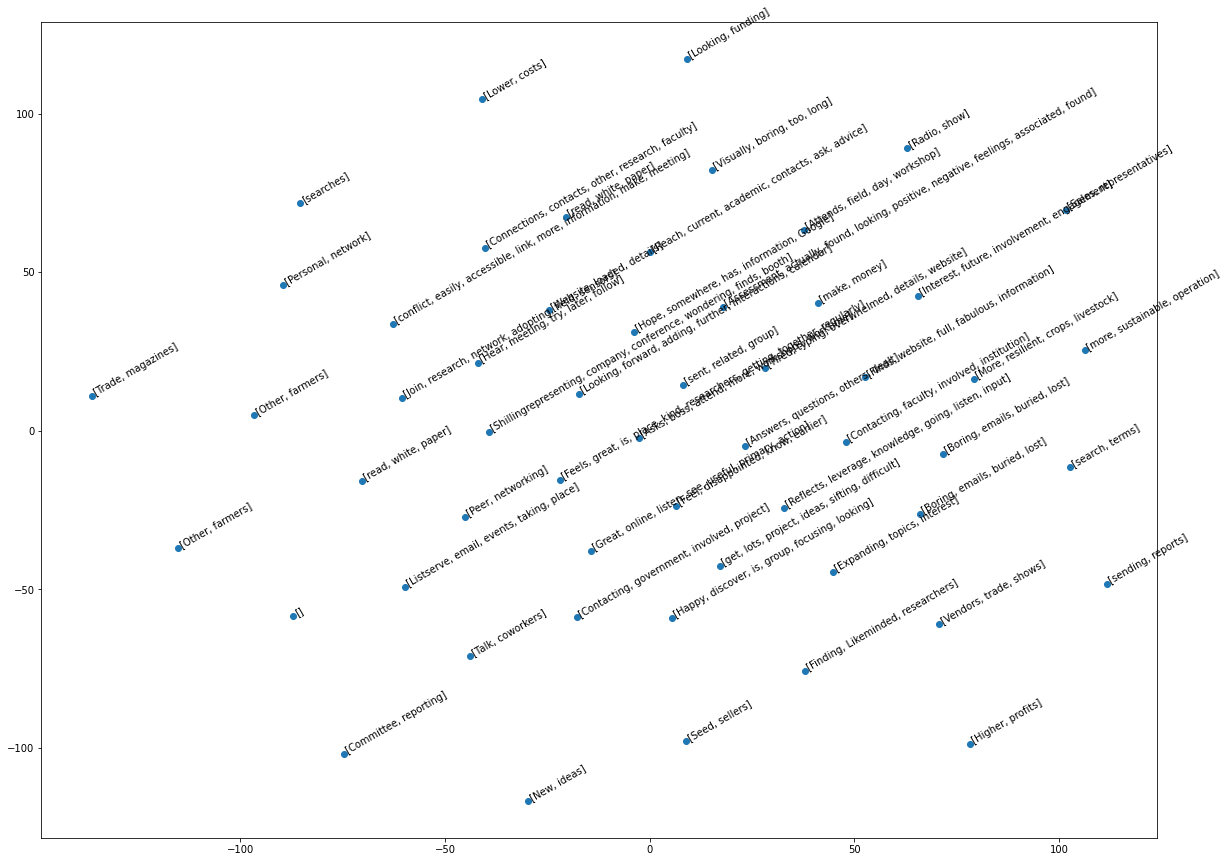

In [575]:

fig = plt.figure(figsize=(20, 15))

ax = fig.gca()

X = projectedData[:,0]
Y = projectedData[:,1]

ax.scatter(X, Y)

for index, lab in enumerate(nounList): 
    ax.text(X[index], Y[index], s=str(lab), rotation=30)
    
plt.show()


0.9821795237351272


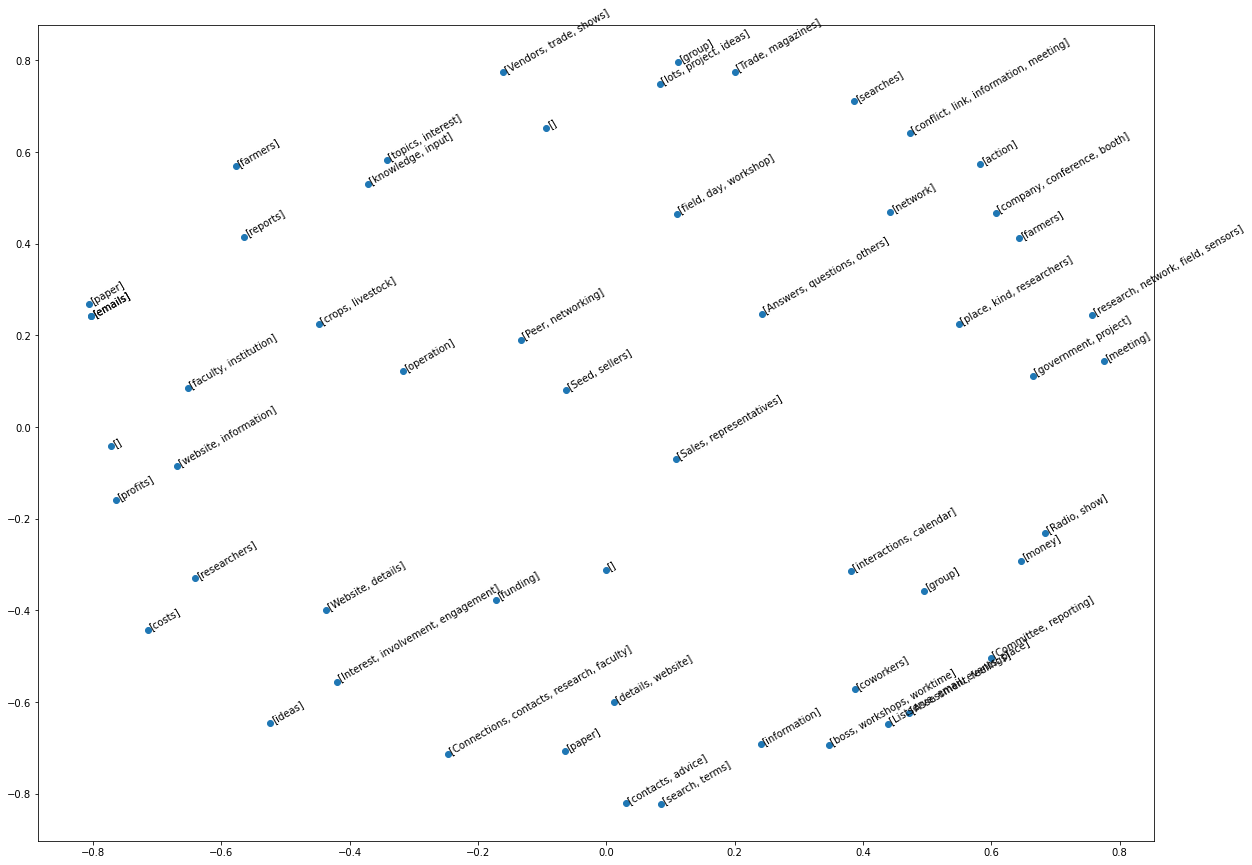

In [576]:
pca = PCA(n_components=30)
reducedData = pca.fit_transform(sumList)
print(sum(pca.explained_variance_ratio_))
dissim = getVectorDist(reducedData)
#dissim = [[1- item for item in innerList] for innerList in getPOSBERTSimList(spanList, ["NOUN", "VERB", "ADJ", "ADV"])]

#MDS on distance matrix (doesn't seem as good)
#Hopefully it is the PROJECTION that doesn't work as well not the PCA before distance ideas 
from sklearn.manifold import MDS 

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=3)
fitted = mds.fit_transform(dissim)
fig = plt.figure(figsize=(20, 15))

ax = fig.gca()

X = fitted[:,0]
Y = fitted[:,1]

ax.scatter(X, Y)

for index, lab in enumerate(nounSpanList): 
    ax.text(X[index], Y[index], s=str(lab), rotation=30)
    
plt.show()


{'Signing up for list serves': '#984EA3', 'Email  calling Pis or admin support people': '#984EA3', 'Setting up the actual interaction is an interaction in itself  and can be positive or negative based on how easy it is to achieve': '#984EA3', 'Attending workshopsevents': '#984EA3', 'Making phone calls': '#984EA3', 'Reading emails  need to keep them engaging or at this point Susan will let emails float down to junk status': '#984EA3', 'Feel like a part of the team when reading from listserve': '#984EA3', 'Learning about the others in the group': '#984EA3', 'Looking for listserves to join': '#984EA3', 'Looking into resources related to their research': '#984EA3', 'Finding contact information to start reaching out': '#984EA3', 'Email': '#984EA3', 'Phone': '#984EA3', 'Listserve': '#984EA3', 'Reading about events that will happen soon': '#984EA3', 'Excited to have a contact': '#984EA3', 'Hopeful': '#984EA3', 'Worried things wont pan out': '#984EA3', 'Afraid that she might have to share IP a

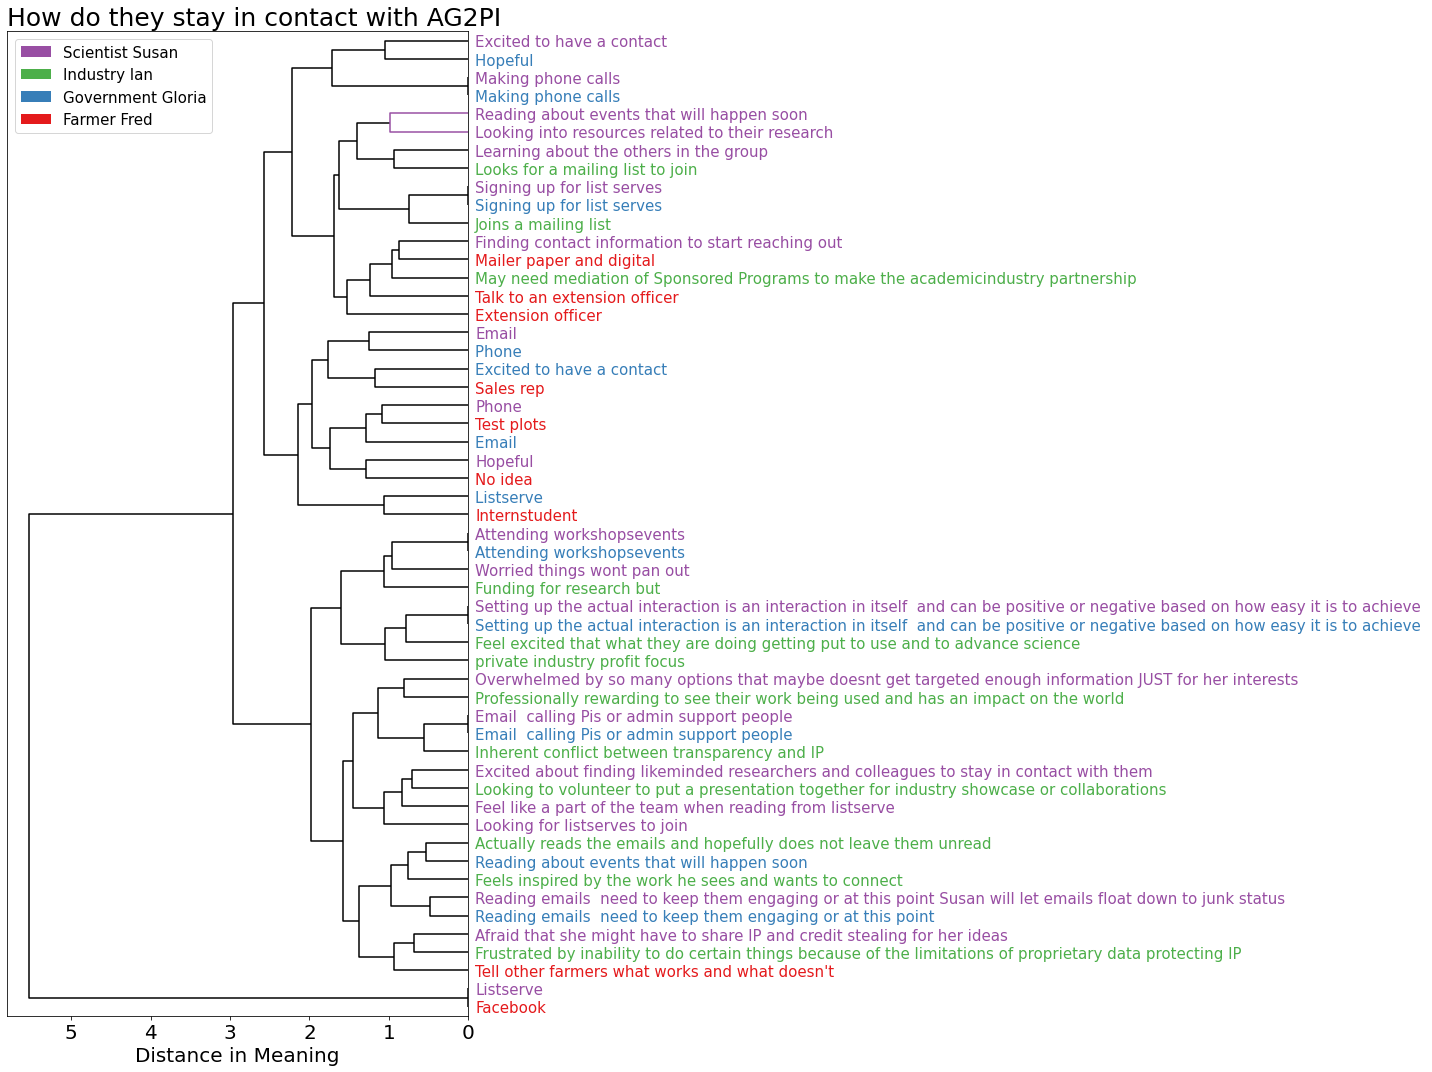

In [561]:
plt.figure(figsize=(20, 15))
ax = clusterNounVerbEmbeddings(["Touchpoint", "Persona"], "workingDoc", getPOSBERTSimList, "How do they stay in contact with AG2PI ")
#D = dendrogram(Z=linked, labels=labelList, orientation="left",color_threshold=None, link_color_func=lambda x: link_cols[x])
ax.tick_params("y", labelsize=15)
ax.tick_params("x", labelsize=20)
#ax.tick_params(axis='both', which='major', labelsize=20)
#plt.rcParams["xtick.labelsize"] = 30
#plt.rcParams["ytick.labelsize"] = 20
ax.set_xlabel("Distance in Meaning", size=20)
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["axes.titlesize"] = 25
#ax.rc('legend',fontsize=15)
#ax.rc("axes", titlesize=25)
#ax.rc("")
ax.set_title("How do they stay in contact with AG2PI ", loc="left")
plt.tight_layout()
plt.savefig("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/mockups/BERTnounVerbSimStayContactQ.jpg")

In [559]:
getPOSBERTSimList(spanList, ["NOUN", "VERB", "ADJ", "ADV"])

[[1,
  0.7548993621924706,
  0.6240453292744448,
  0.6039987519911373,
  0.6361578298642304,
  0.6617099365497806,
  0.7590419724334565,
  0.4826933715223779,
  0.3221940688288696,
  0.5921062067960836,
  0.39625267988191115,
  0.4991930276178691,
  0.42560989588747167,
  0.5002273399648464,
  0.4171423037716222,
  0.4868495378188564,
  0.5576157104436628,
  0.5580762979135269,
  0.7355230252678006,
  0.40959838058574705,
  0.6035978817010044,
  0.6991788980397943,
  0.5029448269244102,
  0.5239327970841435,
  0.5774419034038685,
  0.4978335183631053,
  0.36889815558430306,
  0.5485853304881113,
  1,
  0.4494256212939791,
  0.49193964065867757,
  0.33730532478121766,
  0.7989357575666824,
  0.5753010229899004,
  0.5091216396327022,
  0.3892064135907769,
  0.5229290595080754,
  0.293772654181091,
  0.44315513293605735,
  0.11206092375767907,
  0.16746932872344455,
  0.3231235860426569,
  0.6083742996269452,
  0.47550735417528145,
  0.4886092284700081,
  1,
  0.5796346269696979,
  0.5324

In [ ]:
#Pulling out individual contextual sentance embeddings doesn't seem to work as well 
#regardless of whether we add them all together or perform dimensionality reduction